In [1]:
import numpy as np
import sys
import os
import scipy.io
current_notebook_dir = os.getcwd()
# Replace with the path to your IT_PI.py function
project_root_dir = os.path.join(current_notebook_dir, '..', '..')
it_pi_module_dir = project_root_dir
sys.path.append(it_pi_module_dir)
import IT_PI
import matplotlib as plt
from numpy.linalg import inv, matrix_rank
from pprint import pprint
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering/', VIEW.as_view(), name='')

In [2]:
# Read the data
mat_data  = scipy.io.loadmat('mat/inv_transf.mat')
X         = mat_data['input'] # Load the .mat file, [Y1,Rho1,Mu1,Rhow,Muw,Utau]
Y         = mat_data['output'] # The output is u/utau
index_data = mat_data['index']
index_data = index_data.ravel()
# Read the compressible reference data
data      = scipy.io.loadmat('mat/incom_ref.mat')
y_plus    = data['y_plus']
U_utau    = data['U_utau']
print('input shape: ', X.shape)
D_in      = np.matrix('1  -3  -1 -3 -1 1; 0 0 -1 0 -1 -1; 0 1 1 1 1 0')
num_input = 1

print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_basis           = D_in.shape[1] - matrix_rank(D_in)
basis_matrices      = IT_PI.calc_basis(D_in, num_basis)
basis_matrices[2,:] = -basis_matrices[2,:]  # Adjust the third basis vector
print("Basis vectors:")
pprint(basis_matrices)

input shape:  (1109, 6)
Rank of D_in: 3
D_in matrix:
 [[ 1 -3 -1 -3 -1  1]
 [ 0  0 -1  0 -1 -1]
 [ 0  1  1  1  1  0]]
Basis vectors:
matrix([[ 0.,  1.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0., -1.,  0.],
        [ 1.,  1., -1., -0., -0.,  1.]])


In [3]:
# Run dimensionless learning
results = IT_PI.main(
    X,
    Y.reshape(-1, 1),  # Ensure Y is a 2D array
    basis_matrices= basis_matrices,
    num_input=num_input,
    estimator="binning",
    estimator_params={"num_bins": 40},
    seed =666666,
    optimize_output= True
)

------------------------------------------------------------
num of parameters: 6

Using estimator: 'binning' with hyperparameters: {'num_bins': 40}

(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 6 (seed=666666, Wed Aug 27 10:15:41 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 -2.733745639840682e+00 1.0e+00 7.75e-01  7e-01  8e-01 0:00.1
    2    600 -2.767176400030598e+00 2.3e+00 8.86e-01  6e-01  8e-01 0:00.2
    3    900 -2.934454605190884e+00 3.2e+00 8.88e-01  3e-01  8e-01 0:00.4
   20   6000 -3.035077546227421e+00 3.9e+02 2.19e+00  2e-02  8e-01 0:03.4
   42  12600 -3.082596577791094e+00 1.1e+03 7.89e+00  5e-04  2e-01 0:07.6
   68  20400 -3.093911759648699e+00 1.0e+03 2.63e+01  1e-05  3e-03 0:12.8
   81  24300 -3.093911759648699e+00 1.8e+03 4.49e+01  3e-06  2e-03 0:15.2
termination on tolflatfitness=1
final/bestever f-value = -3.093912e+00 -3.094677e+00 after 24300/18902 evaluations
incumbent solution: [-0.68817146, -0.24547009, 0.65

In [4]:
# Display results
print("Irreducible error:", results["irreducible_error"])
print("Uncertainty:", results["uncertainty"])

input_PI  = results["input_PI"]
output_PI = results["output_PI"]
epsilon   = results["irreducible_error"]
uq        = results["uncertainty"]
a_list    = results["input_coef_basis"]
a_list_o  =results["output_coef_basis"]
variables_pi_i = ['(\\frac{\\rho}{\\rho_w})', '(\\frac{\\mu}{\\mu_w})', '(\\frac{y \\rho u_{\\tau}}{\\mu})']
variables_pi_o = ['(\\frac{\\rho}{\\rho_w})', '(\\frac{\\mu}{\\mu_w})', '(\\frac{y \\rho u_{\\tau}}{\\mu})']
Pi_i_lab = IT_PI.create_labels(a_list, variables_pi_i)
Pi_o_lab = IT_PI.create_labels(a_list_o, variables_pi_o)
# Print the labels
for j, label in enumerate(Pi_i_lab):
    print(f'Pi_i_lab[{j}] = {label}')
for j, label in enumerate(Pi_o_lab):
    Pi_o_lab[j] = r'$\frac{u}{u_{\tau}} \cdot ' + label[1:]  # Remove the first '$' to merge the LaTeX strings properly
for j, label in enumerate(Pi_o_lab):
    print(f'Pi_o_lab[{j}] = {label}')

Irreducible error: [0.27518614525550317]
Uncertainty: [0.12126326185119002]
Pi_i_lab[0] = $\frac{(\frac{y \rho u_{\tau}}{\mu})^{1.0}}{(\frac{\rho}{\rho_w})^{1.06} \cdot (\frac{\mu}{\mu_w})^{0.38}}$
Pi_o_lab[0] = $\frac{u}{u_{\tau}} \cdot (\frac{\rho}{\rho_w})^{1.44} \cdot (\frac{\mu}{\mu_w})^{1.23}$


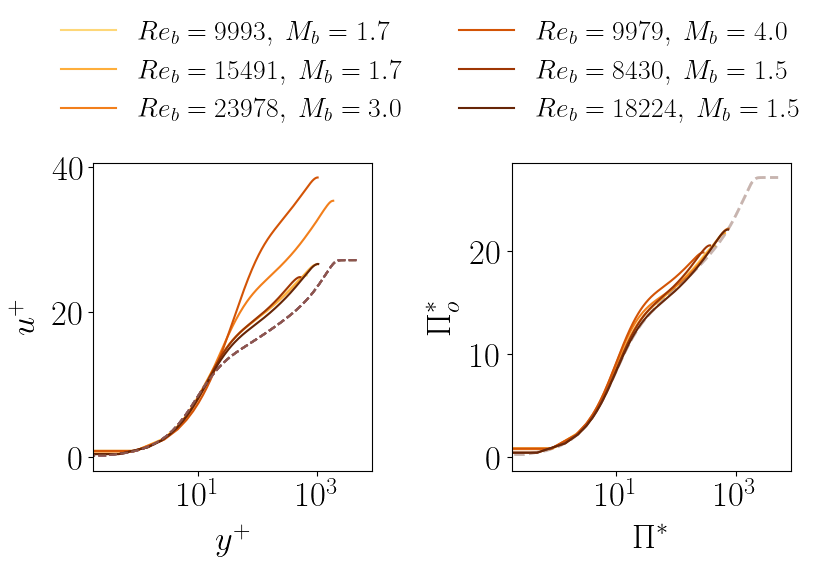

In [5]:
import matplotlib.pyplot as plt


Re_b_values = [9993, 15491, 23978, 9979, 8430, 18224]
M_b_values  = [1.70, 1.70, 3.00, 4.00, 1.50, 1.50]
unique_indices = np.unique(index_data)
cmap = plt.get_cmap('YlOrBr')
colors = [cmap(i) for i in np.linspace(0.3, 1, 6)]# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 4))  # 1 row, 2 columns
# First subplot (Traditional scaling)
for i, idx in enumerate(unique_indices):
    mask = index_data == idx  # Find the points that correspond to the current index
    axes[0].semilogx(
        X[mask, 0] * X[mask, 5] / (X[mask, 4] / X[mask, 3]),
        Y[mask],
        '-',
        label=f'$Re_b={Re_b_values[i]},~M_b={M_b_values[i]}$',
        color=colors[i]
    )
    axes[0].semilogx(y_plus, U_utau, '--')
axes[0].set_xlabel(r'$y^+$', fontsize=25, labelpad=8)
axes[0].set_ylabel(r'$u^+$', fontsize=25, labelpad=8)
axes[0].tick_params(axis='both', labelsize=25)

# Second subplot (IT-pi scaling)
for i, idx in enumerate(unique_indices):
    mask = index_data == idx  # Find the points that correspond to the current index
    axes[1].semilogx(
        input_PI[mask, 0],
        output_PI[mask],
        '-',
        label=f'$Re_b={Re_b_values[i]},~M_b={M_b_values[i]}$',
        color=colors[i]
    )
    axes[1].semilogx(y_plus, U_utau, '--', linewidth=2, alpha=0.1)
axes[1].set_xlabel(r'$\Pi^*$', fontsize=25, labelpad=8)
axes[1].set_ylabel(r'$\Pi_o^*$', fontsize=25, labelpad=8)
axes[1].tick_params(axis='both', labelsize=25)

plt.subplots_adjust(wspace=0.5)
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l

unique = dict(zip(labels, handles))  # Use dictionary to ensure uniqueness
handles, labels = unique.values(), unique.keys()

# Create a shared legend
fig.legend(
    handles,
    labels,
    loc='upper center',
    fontsize=20,
    ncol=2,  # Adjust the number of columns
    bbox_to_anchor=(0.5, 1.3),  # Position above the plots
    frameon=False
)

# Save and show the plots
# plt.savefig('Trans_ch_pipe.png', dpi=300, bbox_inches='tight')
# plt.savefig('Trans_ch_pipe.eps', dpi=300, bbox_inches='tight',transparent = 'True')
plt.show()